## initiation and preparation
___

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf, erfc, erfcinv
from scipy.optimize import minimize

from mpl_toolkits.mplot3d import Axes3D
from cell_library import loadparams

In [2]:
TC = np.load('data\\ExpTF_exc_Nstp40_new.npy').T
RE = np.load('data\\ExpTF_inh_Nstp40_new.npy').T
ve = np.linspace(0, 40, 40)
vi = np.linspace(0, 170, 40)

vve, vvi = np.meshgrid(ve, vi)

Text(0, 0.5, 'vout TC')

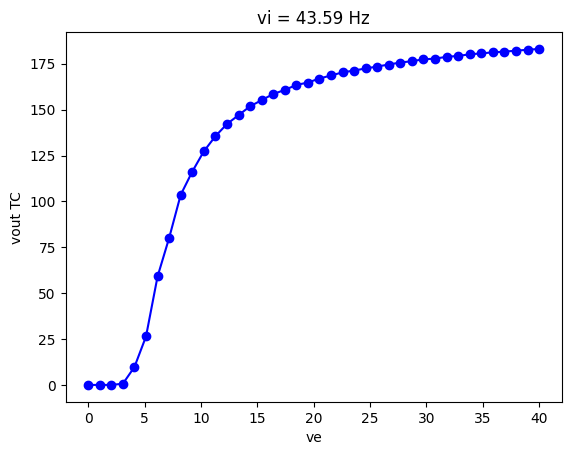

In [3]:
i = 10 # choose inhibitory input

plt.plot(ve, RE[i], '-ob')
# plt.plot(ve, RS2[i], '-or')
plt.title(f'vi = {vi[i]:.2f} Hz')
plt.xlabel('ve')
plt.ylabel('vout TC')

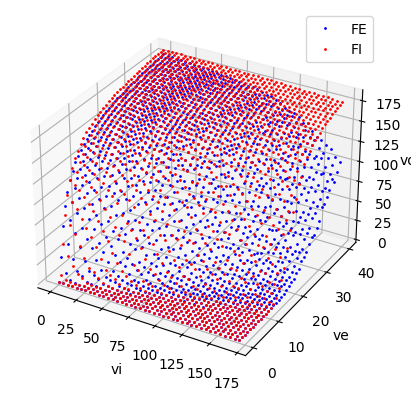

In [4]:
ax = plt.axes(projection='3d')
ax.plot3D(vvi.flatten(), vve.flatten(), TC.flatten(), 'ob', markersize=1,label='FE')
ax.plot3D(vvi.flatten(), vve.flatten(), RE.flatten(), 'or', markersize=1,label='FI')

ax.set_xlabel('vi')
ax.set_ylabel('ve')
ax.set_zlabel('vout')
ax.legend();

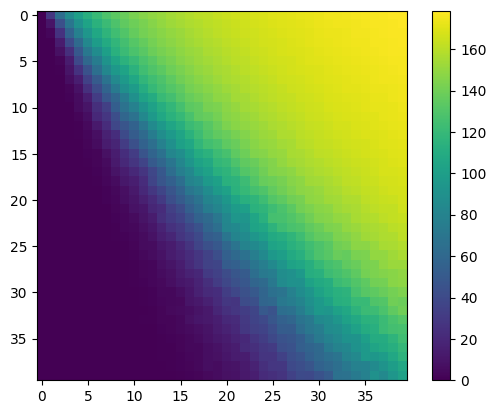

In [5]:
plt.imshow(TC)
plt.colorbar()

In [5]:
params = loadparams('thalamus_ACh')

In [6]:
params['TC']

{'P': 0,
 'Nexc': 800,
 'Ninh': 25,
 'Qe': 1e-09,
 'Qi': 6e-09,
 'Cm': 1.6e-10,
 'El': -0.065,
 'Gl': 1e-08,
 'Tw': 0.2,
 'a': 0,
 'b': 1e-11,
 'Ti': 0.005,
 'Te': 0.005,
 'Ee': 0,
 'Ei': -0.08}

## theory and functions
___

$ \mu_{Ge}(\nu_e,\nu_i)=\nu_eK_e\tau_eQ_e $

$ \mu_{Gi}(\nu_e,\nu_i)=\nu_iK_i\tau_iQ_i $

$ \mu_G(\nu_e,\nu_i)=\mu_{Ge}+\mu_{Gi}+g_L $

$ \tau_m^\text{eff}(\nu_e,\nu_i)=\frac{C_m}{\mu_G} $

$ \mu_V=\frac{\mu_{Ge}E_e+\mu_{Gi}E_i+g_LE_L-w}{\mu_G} $

$ \mu_V=\frac{\mu_{Ge}E_e+\mu_{Gi}E_i+g_LE_L-\nu_\text{out}\tau_wb+aE_L}{\mu_G+a} $

$ \sigma_V(\nu_e,\nu_i)=\sqrt{\sum_sK_s\nu_s\frac{(U_s\cdot\tau_s)^2}{2(\tau_m^\text{eff}+\tau_s)}} $

$ \tau_V(\nu_e,\nu_i)=\left(\frac{\sum_sK_s\nu_s(U_s\cdot\tau_s)^2}{\sum_sK_s\nu_s(U_s\cdot\tau_s)^2/(\tau_m^\text{eff}+\tau_s)}\right) $

$ U_s=\frac{Q_s}{\mu_G}(E_s-\mu_V) $

$ \nu_\text{out}=\frac{1}{2\tau_V}\cdot\text{Erfc}\left(\frac{V_\text{thr}^\text{eff}-\mu_V}{\sqrt{2}\sigma_V}\right) $

$ V_\text{thr}^\text{eff}(\mu_V,\sigma_V,\tau_V^N)=P_0+\sum_{x\in\{\mu_V,\sigma_V,\tau_V^N\}}P_x\cdot\left(\frac{x-x^0}{\delta x^0}\right)+\sum_{x,y\in\{\mu_V,\sigma_V,\tau_V^N\}^2}P_{xy}\cdot\left(\frac{x-x^0}{\delta x^0}\right)\left(\frac{y-y^0}{\delta y^0}\right) $

$ \text{MPF}:(\nu_e,\nu_i)\longrightarrow(\mu_V,\sigma_V,\tau_V,\tau_V^N) $

In [7]:
def MPF(typ,fexc,finh,fout):

    p = params[ typ ]
    P,Nexc,Ninh,Qe,Qi,Cm,El = p.P,p.Nexc,p.Ninh,p.Qe,p.Qi,p.Cm,p.El
    a,b,Tw,Gl,Te,Ti,Ee,Ei = p.a,p.b,p.Tw,p.Gl,p.Te,p.Ti,p.Ee,p.Ei

    fexc[fexc<1e-9]=1e-9
    fe = fexc*Nexc
    finh[finh<1e-9]=1e-9
    fi = finh*Ninh


    muGi = Qi*Ti*fi
    muGe = Qe*Te*fe
    muG = Gl+muGe+muGi
    muV = (muGe*Ee+muGi*Ei+Gl*El - fout*Tw*b + a*El)/(muG+a)
    
    
    muGn = muG/Gl
    Tm = Cm/muG
    
    Ue =  Qe/muG*(Ee-muV)
    Ui = Qi/muG*(Ei-muV)

    sV = np.sqrt(fe*(Ue*Te)*(Ue*Te)/2./(Te+Tm)+fi*(Ui*Ti)*(Ui*Ti)/2./(Ti+Tm))

    Tv = ( fe*(Ue*Te)*(Ue*Te) + fi*(Qi*Ui)*(Qi*Ui)) /( fe*(Ue*Te)*(Ue*Te)/(Te+Tm) + fi*(Qi*Ui)*(Qi*Ui)/(Ti+Tm) )
    TvN = Tv*Gl/Cm

    return muV, sV, Tv, TvN

In [8]:
# test MPF function
typ = 'TC'
xe, xi = 4, 30

m, s, t, _ = MPF(typ, np.array([xe]), np.array([xi]), 0)
print(f'MPF_{typ}: (ve={xe}, vi={xi})Hz -> (mu={m[0]*1e3:.2f}, sigma={s[0]*1e3:.2f}, tau={t[0]*1e3:.2f})mV')

MPF_TC: (ve=4, vi=30)Hz -> (mu=-50.52, sigma=4.50, tau=8.30)mV


In [9]:
#====== calculate MPF for TC/RE =======

#-choose here the neuron typ:
typ = 'RE'
#---------------------------

exec(f'FF={typ}')
muV, sV, Tv, TvN = MPF(typ, vve, vvi, FF)

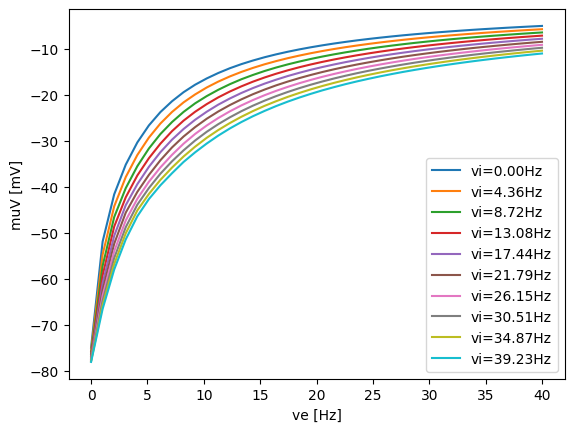

In [10]:
for i in range(10):
    plt.plot(ve,muV[i]*1e3,label=f'vi={vi[i]:.2f}Hz')
    # plt.plot(ve,sV[i]*1e3,label=f'vi={vi[i]:.2f}Hz')

plt.xlabel('ve [Hz]')
plt.ylabel('muV [mV]')
plt.legend();

In [11]:
def pheV(fout, muV, sV, Tv):
    fout[fout<0]=1e-9
    Tv[Tv<0]=1e-9
    return np.sqrt(2)*sV * erfcinv( 2*Tv*fout ) + muV # Zerlaut 2017
    # return np.sqrt(2)*sV * erfcinv( Tv*fout ) + muV # to widen the definition range

Text(0, 0.5, 'Veff [mV]')

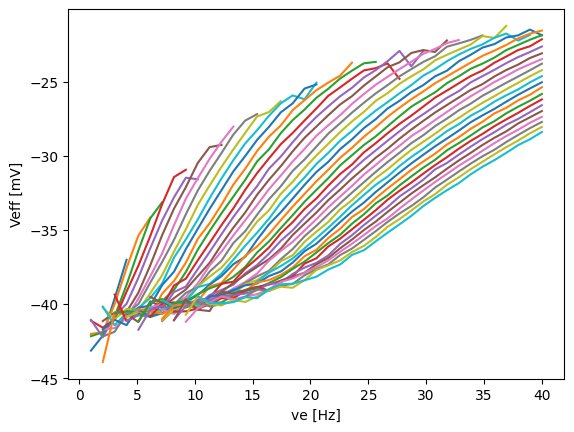

In [12]:
#====== calculate phenomenological V_thr^eff ======
Veff = pheV(FF, muV, sV, Tv)

for i in range(len(vi)):
    plt.plot(ve, Veff[i]*1e3,label=f'vi={vi[i]:.2f}Hz')

plt.xlabel('ve [Hz]')
plt.ylabel('Veff [mV]')
# plt.legend(loc=(1.2,-1.2));

In [13]:
# remove dimension so that no NaN entries are there anymore
# ONLY important for fitting the Vthr

#--------ACh
if typ=='TC': idx = '[15:38,8:35]'
elif typ=='RE': idx = '[20:40,10:]'


exec(f"Veff_fit = Veff{idx}")
# exec(f"TC_fit = TC{idx}")
# exec(f"RE_fit = RE{idx}")
exec(f"muV_fit = muV{idx}")
exec(f"sV_fit = sV{idx}")
exec(f"Tv_fit = Tv{idx}")
exec(f"TvN_fit = TvN{idx}")
Veff_fit.shape

(20, 30)

False

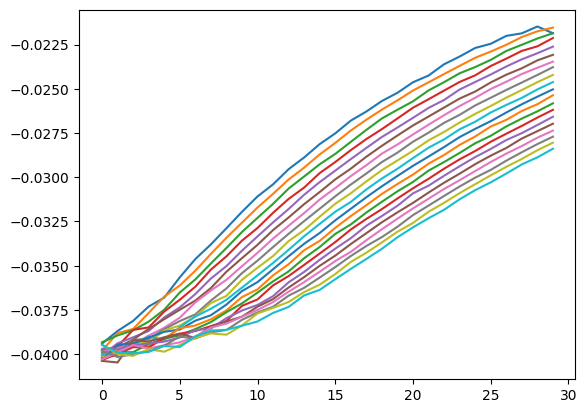

In [14]:
plt.plot(Veff_fit.T);
np.isnan(Veff_fit).any() or np.isinf(Veff_fit).any()

## fitting and results
___

#### fitting first order to find correct global minimum

In [15]:
# calculating the effective threshold potential with a general second order polynomial of the membrane moments (mu,sigma,tau)

def Vthre(P, muV, sV, TvN):
    # normalizing moments:
    muV0 = -60e-3;
    DmuV0 = 10e-3;
    sV0 = 4e-3;
    DsV0 = 6e-3;
    TvN0 = 0.5;
    DTvN0 = 1.;
    
    # first order polynomial
    Vo1 = P[0] + P[1]*(muV-muV0)/DmuV0 + P[2]*(sV-sV0)/DsV0 + P[3]*(TvN-TvN0)/DTvN0
    # second order polynomial
    Vo2 = P[4]*((muV-muV0)/DmuV0)*((muV-muV0)/DmuV0) + P[5]*(muV-muV0)/DmuV0*(sV-sV0)/DsV0 + P[6]*(muV-muV0)/DmuV0*(TvN-TvN0)/DTvN0 + P[7]*((sV-sV0)/DsV0)*((sV-sV0)/DsV0) + P[8]*(sV-sV0)/DsV0*(TvN-TvN0)/DTvN0  + P[9]*((TvN-TvN0)/DTvN0)*((TvN-TvN0)/DTvN0);

    return Vo1 + Vo2
    

In [16]:
# fitting first order Vthr on the phenomenological threshold space

def Res(P): return np.mean( (Veff_fit - Vthre(np.concatenate([P,[0]*6]), muV_fit, sV_fit, TvN_fit))**2 )

res = minimize(Res, [Veff_fit.mean(),1e-3,1e-3,1e-3], method='nelder-mead', tol=1e-20, options={'disp':True,'maxiter':20000})
# res = minimize(Res, [Veff_fit.mean(),1e-3,1e-3,1e-3], method='SLSQP', tol=1e-32, options={'disp':True,'maxiter':20000})

P1 = np.array(res.x)
print(P1)

[ 0.07760307 -0.00269062 -0.16646887  0.71054242]


C:\Users\jover\AppData\Local\Temp\ipykernel_23104\1219303345.py:5: RuntimeWarning: Maximum number of iterations has been exceeded.
  res = minimize(Res, [Veff_fit.mean(),1e-3,1e-3,1e-3], method='nelder-mead', tol=1e-20, options={'disp':True,'maxiter':20000})


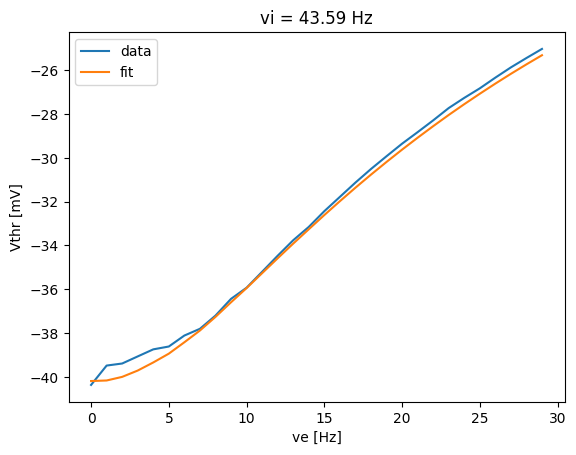

In [17]:
# checking the fit...

# choose vi:
i=10

plt.title(f'vi = {vi[i]:.2f} Hz')

plt.plot(Veff_fit[i]*1e3, label='data')
plt.plot(Vthre(np.concatenate([P1,[0]*6]), muV_fit, sV_fit, TvN_fit)[i]*1e3, label='fit')
plt.xlabel('ve [Hz]')
plt.ylabel('Vthr [mV]')
plt.legend();


___
skippable 

In [97]:
# fit the second order parameters on Vthre ( not necessary most of the time!!!! -> SKIP )
def Res(P): return np.mean( (Veff_fit - Vthre(np.concatenate([P1,P]), muV_fit, sV_fit, TvN_fit))**2 )

res = minimize(Res, [1e-6]*6, method='nelder-mead', tol=1e-20, options={'disp':True,'maxiter':20000})
# res = minimize(Res, [0]*6, method='SLSQP', options={'ftol':1e-20,'disp':True,'maxiter':20000})

P2 = np.array(res.x)
print(P2)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1216
         Function evaluations: 2125
[-2.11688909e-05 -1.04633434e-03 -1.27683930e-04 -1.79823884e-03
 -1.73390749e-02  3.50871394e-03]


In [98]:
P = np.concatenate([P1,P2])

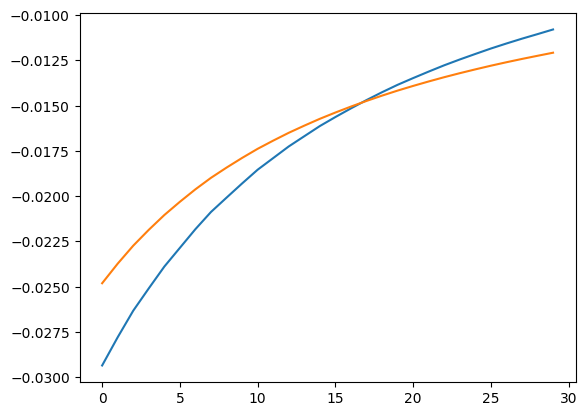

In [102]:
i =0
plt.plot(Veff_fit[i])
plt.plot(Vthre(P, muV_fit, sV_fit, TvN_fit)[i])

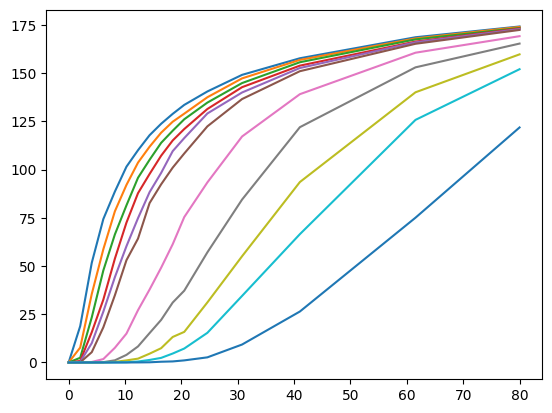

In [80]:
# choose a subspace to fit the firing rate and transfer function ( not necessary BUT produces better results most of the time )
# IMPPORTANT if a subspace in firing rate input is more interesting or badly fitted without doing this ...

# red = [0,1,2,3,4,5,10,15,20,21,22,23,24,25,30,31,32,33,34,35,36,37,38,39]
# rid = [0,1,2,3,4,5,7,10,15,20,25,29]

# plt.plot(ve,FF[rid].T);
# plt.plot(ve[red],FF[:,red].T);
plt.plot(ve[red],FF[rid][:,red].T);
# FF[:].size

skippable
___

In [18]:
# the transfer function
def TF(P, muV, sV, Tv, TvN):
    fout = 1/(2*Tv) * erfc( (Vthre(P, muV, sV, TvN) - muV)/(np.sqrt(2)*sV) )
    
    # fout = np.where(fout<0, 1e-9, fout)
    fout[fout<0]=0
    return fout

In [19]:
def Res(P):
    # return np.mean( (TC_fit - TF(P, muV_fit, sV_fit, Tv_fit, TvN_fit))**2 )
    return np.mean( (FF - TF(P, muV, sV, Tv, TvN))**2 )
    # return np.mean( (FF[rid] - TF(P, muV[rid], sV[rid], Tv[rid], TvN[rid]))**2 )
    # return np.mean( (FF[:,red] - TF(P, muV[:,red], sV[:,red], Tv[:,red], TvN[:,red]))**2 )
    # return np.mean( (FF[rid][:,red] - TF(P, muV[rid][:,red], sV[rid][:,red], Tv[rid][:,red], TvN[rid][:,red]))**2 )

# res = minimize(Res, P, method='nelder-mead', tol=1e-20, options={'disp':True,'maxiter':20000})
res = minimize(Res, np.concatenate([P1,[1e-6]*6]), method='nelder-mead', tol=1e-20, options={'disp':True,'maxiter':20000})
# res = minimize(Res, np.concatenate([[Veff_fit.mean(),1e-3,1e-3,1e-3],[0]*6]), method='nelder-mead', tol=1e-20, options={'disp':True,'maxiter':20000})
# res = minimize(Res, np.concatenate([P1,[1e-6]*6]), method='SLSQP', options={'ftol':1e-20,'disp':True,'maxiter':40000})

PP = np.array(res.x)
print(PP)

[-0.0420878  -0.00179005  0.00324451 -0.002093    0.00125195 -0.00180364
 -0.00269887  0.00149767 -0.00028795  0.00043561]


C:\Users\jover\AppData\Local\Temp\ipykernel_23104\390806286.py:9: RuntimeWarning: Maximum number of iterations has been exceeded.
  res = minimize(Res, np.concatenate([P1,[1e-6]*6]), method='nelder-mead', tol=1e-20, options={'disp':True,'maxiter':20000})


In [80]:
TF(PP, muV, sV, Tv, TvN)[10]

array([5.77417046e-09, 1.57701455e+00, 1.80892972e+01, 4.48176788e+01,
       6.77041238e+01, 8.72913501e+01, 1.03259519e+02, 1.16738683e+02,
       1.26887479e+02, 1.34677091e+02, 1.41091419e+02, 1.45977114e+02,
       1.50048887e+02, 1.53309823e+02, 1.56116075e+02, 1.58499361e+02,
       1.60552436e+02, 1.62329477e+02, 1.63893552e+02, 1.65302718e+02])

| vi = 43.59Hz |


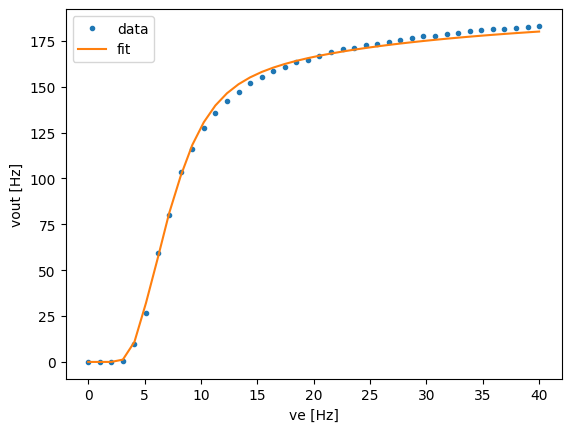

In [20]:
# compare fit

# choose vi...
i=10

print(f'| vi = {vi[i]:.2f}Hz |')

plt.plot(ve,FF[i], 'o', ms=3, label='data')
plt.plot(ve,TF(PP, muV, sV, Tv, TvN)[i], label='fit')
# plt.plot(ve,TF(params['FS'].P, muV, sV, Tv, TvN)[i], label='fit')

plt.xlabel('ve [Hz]')
plt.ylabel('vout [Hz]')
plt.legend();
# plt.xlim(0,20)

In [140]:
#===== SAVE fitted parameters ======

np.save(f'data\\FITparams_{typ}_new.npy', PP)

___
___

In [21]:
plt.rcParams.update({'font.size': 15})

| vi = (21.79, 43.59, 65.38)Hz |


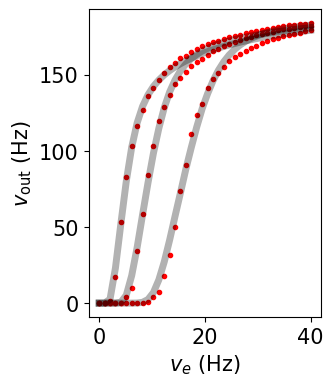

In [26]:
# compare fit
plt.figure(figsize=(3,4))
# choose vi...
i=5

print(f'| vi = ({vi[i]:.2f}, {vi[2*i]:.2f}, {vi[3*i]:.2f})Hz |')

plt.plot(ve,FF[i], 'or', ms=3, label='spiking TC')
plt.plot(ve,FF[3*i], 'or', ms=3)
plt.plot(ve,FF[6*i], 'or', ms=3)
plt.plot(ve,TF(PP, muV, sV, Tv, TvN)[i], '-k',lw=5,alpha=.3, label='$v_i=22$Hz')
plt.plot(ve,TF(PP, muV, sV, Tv, TvN)[3*i], '-k',lw=5,alpha=.3, label='$v_i=44$Hz')
plt.plot(ve,TF(PP, muV, sV, Tv, TvN)[6*i], '-k',lw=5,alpha=.3, label='$v_i=65$Hz')
# plt.plot(ve,TF(params['FS'].P, muV, sV, Tv, TvN)[i], label='fit')

plt.xlabel('$v_e$ (Hz)')
plt.ylabel('$v_{\mathrm{out}}$ (Hz)')
# plt.legend();
# plt.xlim(0,20)
# plt.savefig('fitpaper_RE.png',dpi=200,bbox_inches='tight')

___
#### - END -
___